<H1> Model

In [8]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# stocks
long_tickers = [
    'CEG', 'LH', 'BA', 'CARR', 'DOW', 'PH', 'EMR', 'JBL', 'SWK', 'URI', 'BSX', 'DLTR', 
    'ORCL', 'HUBB', 'LYB', 'XYL', 'HON', 'DD', 'ROP', 'UNH', 'IBM', 'GRMN', 'CMI', 'BKR', 
    'GLW', 'SYK', 'FTV', 'ETN', 'CHD', 'OTIS', 'PCAR', 'DGX', 'AME', 'DRI', 'APH', 'AOS', 
    'HUM', 'CLX', 'ORLY', 'CTAS', 'ECL', 'TER', 'TMUS', 'MAS', 'TDG', 'JNPR', 'NSC', 'FAST', 
    'PAYX', 'ROK', 'ITW', 'CSCO', 'CPRT', 'TMO', 'OKE', 'EXC', 'EMN', 'PWR', 'NEM', 'DOV', 
    'VTR', 'TXT', 'TXN', 'PG', 'AVY', 'DTE', 'MGM', 'BR', 'GD', 'ADP', 'PPL', 'NI', 'MLM', 
    'IDXX', 'HCA', 'SHW', 'HWM', 'ZTS', 'RCL', 'GWW', 'CDW', 'CAH', 'HPE', 'HD', 'HSY', 'RTX', 
    'UNP', 'MCK', 'AES', 'FICO', 'INTC', 'JCI', 'ATO', 'HAS', 'LOW', 'ALLE', 'WELL', 'ISRG', 
    'VRSN', 'TRGP', 'LMT'
]

short_tickers = [
    'ETSY', 'DXCM', 'ILMN', 'PAYC', 'VFC', 'ABNB', 'APA', 'UPS', 'EPAM', 'CHTR', 'MOS', 
    'EXPE', 'MPC', 'PANW', 'VLO', 'COR', 'BXP', 'MRO', 'HAL', 'MRNA'
]

# Add '^GSPC' for market data (S&P 500)
tickers = long_tickers + short_tickers + ['^GSPC']

# Pull historical data, now including S&P 500
data = yf.download(tickers, start="2022-01-01", end="2024-11-13")['Adj Close']
data = data.dropna()


S_P = ['^GSPC']


# BETAS:
# Calculate daily returnss
returns = data.pct_change().dropna()

# Calculate market returns (S&P 500)
market_returns = returns['^GSPC']

# Calculate covariance of each asset with the market (manually)
cov_market = {}
for ticker in tickers:
    if ticker != '^GSPC':
        cov_market[ticker] = returns[ticker].cov(market_returns)

# Calculate the market variance
market_variance = market_returns.var()

# Calculate the betas for all tickers relative to the market
betas = {ticker: cov / market_variance for ticker, cov in cov_market.items()}
print(betas)





# CHOSEN BETAS

# Based off of short or long

# Define the beta threshold
beta_threshold = 0.5

# Filter the betas dictionary for values below the threshold
filtered_betas = {ticker: beta for ticker, beta in betas.items() if beta < beta_threshold}
# print(filtered_betas)

# Filter betas under the threshold and categorize into long and short tickers as lists
filtered_long_betas = [ticker for ticker, beta in betas.items() if beta < beta_threshold and ticker in long_tickers]
filtered_short_betas = [ticker for ticker, beta in betas.items() if beta < beta_threshold and ticker in short_tickers]

# Combine long and short tickers into a single list for optimization
long_short_tickers = filtered_long_betas + filtered_short_betas

# Print the results
print("Filtered Long Tickers with Betas below Threshold:")
print(filtered_long_betas)

print("\nFiltered Short Tickers with Betas below Threshold:")
print(filtered_short_betas)

# PORTFOLIO:

# Only use long and short tickers for the optimization
long_short_tickers = filtered_long_betas  + filtered_short_betas

# Compute the covariance matrix for long and short tickers using pandas, then convert it to a NumPy array
cov_matrix = returns[long_short_tickers].cov().values

# Define initial weights (could be random or set to some starting values)
weights = np.ones(len(long_short_tickers)) 

# Compute the portfolio variance using NumPy's dot product
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

print(f"Portfolio Variance: {portfolio_variance}")





# MINIMIZATION:
import numpy as np
from scipy.optimize import minimize


cov_matrix = returns[long_short_tickers].cov().values
# Redundant
betas_array = np.array(list(filtered_betas.values()))

# Objective function: Portfolio variance
def objective(weights):
    return weights.T @ cov_matrix @ weights

# Constraints: Market neutrality (weights sum to 0) and Beta neutrality
def market_neutrality(weights):
    return np.sum(weights)

def beta_neutrality(weights):
    return np.sum(betas_array * weights)  

# Initial guess for weights
initial_weights = np.ones(len(long_short_tickers))

# Constraints as dictionary format for scipy.optimize
constraints = [
    {'type': 'eq', 'fun': market_neutrality},
    {'type': 'eq', 'fun': beta_neutrality} 
]

# Solve the optimization problem
result = minimize(objective, initial_weights, constraints=constraints)

# Extract the optimized weights
optimized_weights = result.x

print("Optimized Weights:", optimized_weights)

optimized_portfolio = list(zip(long_short_tickers, optimized_weights))
print(" ")
# Print the results
print("Optimized Portfolio Weights:")
for ticker, weight in optimized_portfolio:
    print(f"{ticker}: {weight}")

trailing_stop_loss_pct = 0.03 

data = yf.download(long_short_tickers, start="2022-01-01", end="2024-11-13")['Adj Close']
prices = data[ticker].tolist() 

# Trailing stop loss function
def apply_trailing_stop_loss(prices, stop_loss_pct):
    max_price = max(prices)
    stop_loss_price = max_price * (1 - stop_loss_pct)
    return prices[-1] < stop_loss_price

optimized_portfolio = {}
for ticker, weight in zip(long_short_tickers, optimized_weights):
    optimized_portfolio[ticker] = weight

for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")
    
# Apply trailing stop loss
for ticker, weight in optimized_portfolio.items():
    prices = data[ticker].tolist()  
    if apply_trailing_stop_loss(prices, 0.03):
        print(f"Stop loss triggered for {ticker}. Removing from portfolio.")
        optimized_portfolio[ticker] = 0 

# Updated optimized portfolio
print(" ")
print("Updated Optimized Portfolio:")
for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")

    




# TRAILING FALL OFF
trailing_stop_loss_pct = 0.03 

data = yf.download(long_short_tickers, start="2022-01-01", end="2024-11-13")['Adj Close']
prices = data[ticker].tolist() 

# Trailing stop loss function
removed_stocks = {}

# Apply trailing stop loss and handle re-entry if price recovers
for ticker, weight in optimized_portfolio.items():
    prices = data[ticker].tolist() 
    
    # Apply stop loss
    if apply_trailing_stop_loss(prices, 0.03):
        print(f"Stop loss triggered for {ticker}. Removing from portfolio.")
        optimized_portfolio[ticker] = 0 
        removed_stocks[ticker] = prices[-1]  
    elif ticker in removed_stocks:
        # If the stock was removed and the price goes back up 
        previous_price = removed_stocks[ticker]
        if prices[-1] > previous_price * 1.03: 
            
           #COOL OFF PERIOD
            if last_exit_time[ticker] != current_date:
                print(f"Price of {ticker} has recovered. Adding it back to the portfolio.")
                optimized_portfolio[ticker] = weight  
                del removed_stocks[ticker]  
                del last_exit_time[ticker]  

# Ensure long positions have weights > 0 and short positions have weights < 0
    if ticker in long_tickers and optimized_portfolio[ticker] < 0:
        print(f"Long position violated for {ticker}. Setting weight to 0.")
        optimized_portfolio[ticker] = 0
    elif ticker in short_tickers and optimized_portfolio[ticker] > 0:
        print(f"Short position violated for {ticker}. Setting weight to 0.")
        optimized_portfolio[ticker] = 0
        
# Updated optimized portfolio
print("")
print("Updated Optimized Portfolio:")

for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")




trailing_stop_loss_pct = 0.03 

data = yf.download(long_short_tickers, start="2022-01-01", end="2024-11-13")['Adj Close']
prices = data[ticker].tolist() 

# Trailing stop loss function
def apply_trailing_stop_loss(prices, stop_loss_pct):
    max_price = max(prices)
    stop_loss_price = max_price * (1 - stop_loss_pct)
    return prices[-1] < stop_loss_price

optimized_portfolio = {}
for ticker, weight in zip(long_short_tickers, optimized_weights):
    optimized_portfolio[ticker] = weight

for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")
    
# Apply trailing stop loss
for ticker, weight in optimized_portfolio.items():
    prices = data[ticker].tolist()  
    if apply_trailing_stop_loss(prices, 0.03):
        print(f"Stop loss triggered for {ticker}. Removing from portfolio.")
        optimized_portfolio[ticker] = 0 

# Updated optimized portfolio
print(" ")
print("Updated Optimized Portfolio:")
for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")

    

# TRAILING FALL OFF
trailing_stop_loss_pct = 0.03 

data = yf.download(long_short_tickers, start="2022-01-01", end="2024-11-13")['Adj Close']
prices = data[ticker].tolist() 

# Trailing stop loss function
removed_stocks = {}

# Apply trailing stop loss and handle re-entry if price recovers
for ticker, weight in optimized_portfolio.items():
    prices = data[ticker].tolist()  
    
    # Apply stop loss
    if apply_trailing_stop_loss(prices, 0.03):
        print(f"Stop loss triggered for {ticker}. Removing from portfolio.")
        optimized_portfolio[ticker] = 0  
        removed_stocks[ticker] = prices[-1]  # Store the price when removed
    elif ticker in removed_stocks:
        # If the stock was removed and the price goes back up 
        previous_price = removed_stocks[ticker]
        if prices[-1] > previous_price * 1.03:  #neutral position recovery threshold
            
           #COOL OFF PERIOD
            if last_exit_time[ticker] != current_date:
                print(f"Price of {ticker} has recovered. Adding it back to the portfolio.")
                optimized_portfolio[ticker] = weight  # Restore original weight or set a new weight
                del removed_stocks[ticker]  # Remove from removed stocks tracker
                del last_exit_time[ticker]  # Clear the exit time

# Ensure long positions have weights > 0 and short positions have weights < 0
    if ticker in long_tickers and optimized_portfolio[ticker] < 0:
        print(f"Long position violated for {ticker}. Setting weight to 0.")
        optimized_portfolio[ticker] = 0
    elif ticker in short_tickers and optimized_portfolio[ticker] > 0:
        print(f"Short position violated for {ticker}. Setting weight to 0.")
        optimized_portfolio[ticker] = 0
        
# Updated optimized portfolio
print("")
print("Updated Optimized Portfolio:")

for ticker, weight in optimized_portfolio.items():
    print(f"{ticker}: {weight}")

    

[*********************100%***********************]  122 of 122 completed
[*******               14%                       ]  2 of 14 completed

{'CEG': 1.0009008695928994, 'LH': 0.6614368111322534, 'BA': 1.1065618804305177, 'CARR': 1.1508253567831006, 'DOW': 0.7940485013306052, 'PH': 1.1511643191503718, 'EMR': 0.932559760305993, 'JBL': 1.2620848463348413, 'SWK': 1.1630582972236423, 'URI': 1.4277959075156257, 'BSX': 0.6762275945346956, 'DLTR': 0.6834236078228565, 'ORCL': 1.0017574492053496, 'HUBB': 0.961524177831355, 'LYB': 0.8026258796897834, 'XYL': 1.0810882121741041, 'HON': 0.7774345190689004, 'DD': 0.9999014061460415, 'ROP': 0.7895771265490481, 'UNH': 0.4536850192869232, 'IBM': 0.5671162556160582, 'GRMN': 0.9206546029466116, 'CMI': 0.8266337635005294, 'BKR': 0.7110724224008796, 'GLW': 0.9624519962351596, 'SYK': 0.8950990848866986, 'FTV': 1.0436561648765015, 'ETN': 1.0645837154337714, 'CHD': 0.30693765255816824, 'OTIS': 0.838575435916035, 'PCAR': 0.8059969936024871, 'DGX': 0.47006146067281007, 'AME': 0.8296647392299074, 'DRI': 0.8320843308947288, 'APH': 1.1358761479060404, 'AOS': 0.935930621354166, 'HUM': 0.4059691607038534,

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
[**********            21%                       ]  3 of 14 completed

UNH: -0.00022364402418539875
CHD: -1.4072914074958476e-05
DGX: 0.00043336941541982643
HUM: -0.00035118774221110094
CLX: -0.00013099794298776501
EXC: -5.988295384895537e-05
PG: 0.00016775595294660217
DTE: 1.6429251273875067e-05
CAH: -6.26578061007077e-05
HSY: 4.27841192157663e-05
MCK: -0.00018831068290636743
ATO: 0.0001517170425936465
LMT: 0.00023837648372393438
COR: -1.9678198855954676e-05
Stop loss triggered for HUM. Removing from portfolio.
Stop loss triggered for EXC. Removing from portfolio.
Stop loss triggered for PG. Removing from portfolio.
Stop loss triggered for DTE. Removing from portfolio.
Stop loss triggered for HSY. Removing from portfolio.
Stop loss triggered for LMT. Removing from portfolio.
 
Updated Optimized Portfolio:
UNH: -0.00022364402418539875
CHD: -1.4072914074958476e-05
DGX: 0.00043336941541982643
HUM: 0
CLX: -0.00013099794298776501
EXC: 0
PG: 0
DTE: 0
CAH: -6.26578061007077e-05
HSY: 0
MCK: -0.00018831068290636743
ATO: 0.0001517170425936465
LMT: 0
COR: -1.967819

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed

UNH: -0.00022364402418539875
CHD: -1.4072914074958476e-05
DGX: 0.00043336941541982643
HUM: -0.00035118774221110094
CLX: -0.00013099794298776501
EXC: -5.988295384895537e-05
PG: 0.00016775595294660217
DTE: 1.6429251273875067e-05
CAH: -6.26578061007077e-05
HSY: 4.27841192157663e-05
MCK: -0.00018831068290636743
ATO: 0.0001517170425936465
LMT: 0.00023837648372393438
COR: -1.9678198855954676e-05
Stop loss triggered for HUM. Removing from portfolio.
Stop loss triggered for EXC. Removing from portfolio.
Stop loss triggered for PG. Removing from portfolio.
Stop loss triggered for DTE. Removing from portfolio.
Stop loss triggered for HSY. Removing from portfolio.
Stop loss triggered for LMT. Removing from portfolio.
 
Updated Optimized Portfolio:
UNH: -0.00022364402418539875
CHD: -1.4072914074958476e-05
DGX: 0.00043336941541982643
HUM: 0
CLX: -0.00013099794298776501
EXC: 0
PG: 0
DTE: 0
CAH: -6.26578061007077e-05
HSY: 0
MCK: -0.00018831068290636743
ATO: 0.0001517170425936465
LMT: 0
COR: -1.967819

<H1> Backtest 

Initial Portfolio Value: 1000
Final Portfolio Value: 1000.1037300205992


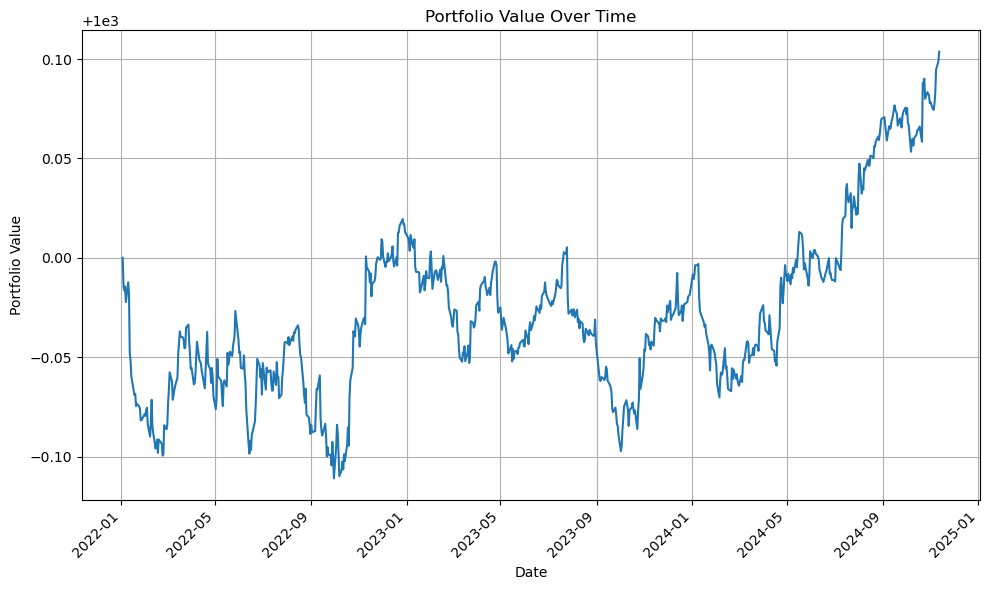

In [10]:
# Backtest function
def backtest(data, optimized_portfolio, long_short_tickers):
    # Calculate daily returns for each stock
    returns = data.pct_change().dropna()
    
    # Initialize portfolio value (starting with $1,000)
    initial_value = 1000
    portfolio_value = initial_value
    portfolio_history = [portfolio_value]
    
    # Iterate through each day of returns
    for date in returns.index:
        # Calculate portfolio return for the day
        portfolio_return = sum(returns.loc[date, ticker] * optimized_portfolio[ticker] for ticker in long_short_tickers)
        
        # Update portfolio value based on the return
        portfolio_value *= (1 + portfolio_return)
        
        # Track portfolio value history
        portfolio_history.append(portfolio_value)
    
    return initial_value, portfolio_value, portfolio_history

# Run the backtest
initial_value, final_value, portfolio_history = backtest(data, optimized_portfolio, long_short_tickers)

# Print initial and final portfolio values
print(f"Initial Portfolio Value: {initial_value}")
print(f"Final Portfolio Value: {final_value}")

# Plot the portfolio value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(data.index, portfolio_history)

# Title and labels
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.show()


Initial Portfolio Value: 1000000
Final Portfolio Value: 1000103.7300205972


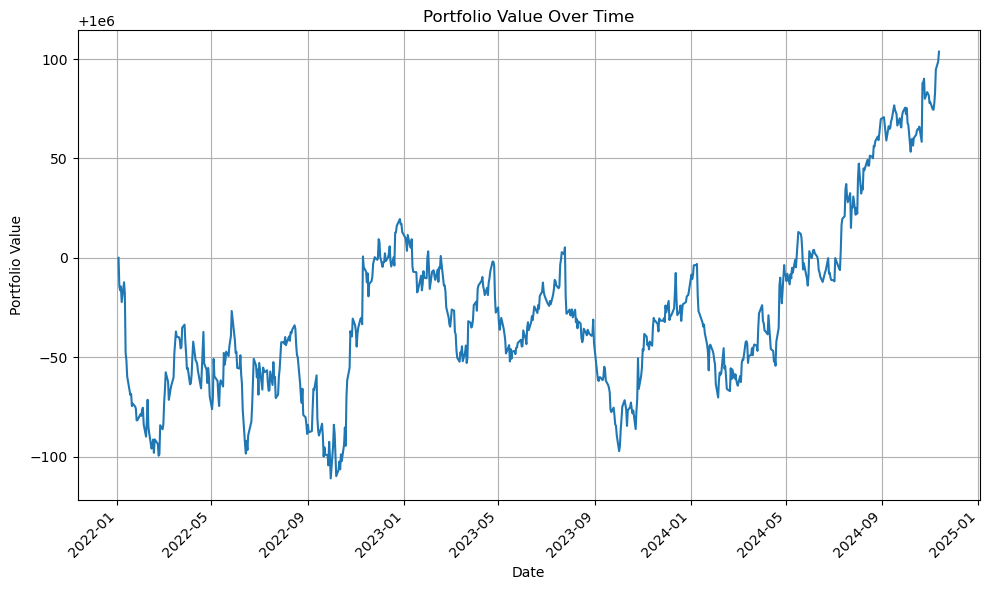

In [11]:
# Backtest function
def backtest(data, optimized_portfolio, long_short_tickers):
    # Calculate daily returns for each stock
    returns = data.pct_change().dropna()
    
    # Initialize portfolio value (starting with $1,000)
    initial_value = 1000000
    portfolio_value = initial_value
    portfolio_history = [portfolio_value]
    
    # Iterate through each day of returns
    for date in returns.index:
        # Calculate portfolio return for the day
        portfolio_return = sum(returns.loc[date, ticker] * optimized_portfolio[ticker] for ticker in long_short_tickers)
        
        # Update portfolio value based on the return
        portfolio_value *= (1 + portfolio_return)
        
        # Track portfolio value history
        portfolio_history.append(portfolio_value)
    
    return initial_value, portfolio_value, portfolio_history

# Run the backtest
initial_value, final_value, portfolio_history = backtest(data, optimized_portfolio, long_short_tickers)

# Print initial and final portfolio values
print(f"Initial Portfolio Value: {initial_value}")
print(f"Final Portfolio Value: {final_value}")

# Plot the portfolio value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(data.index, portfolio_history)

# Title and labels
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.show()


<H1> Sharpe Ratio </h1>

Initial Portfolio Value: 1000
Final Portfolio Value: 1000.1037300205992
Sharpe Ratio: 0.02175657831223627


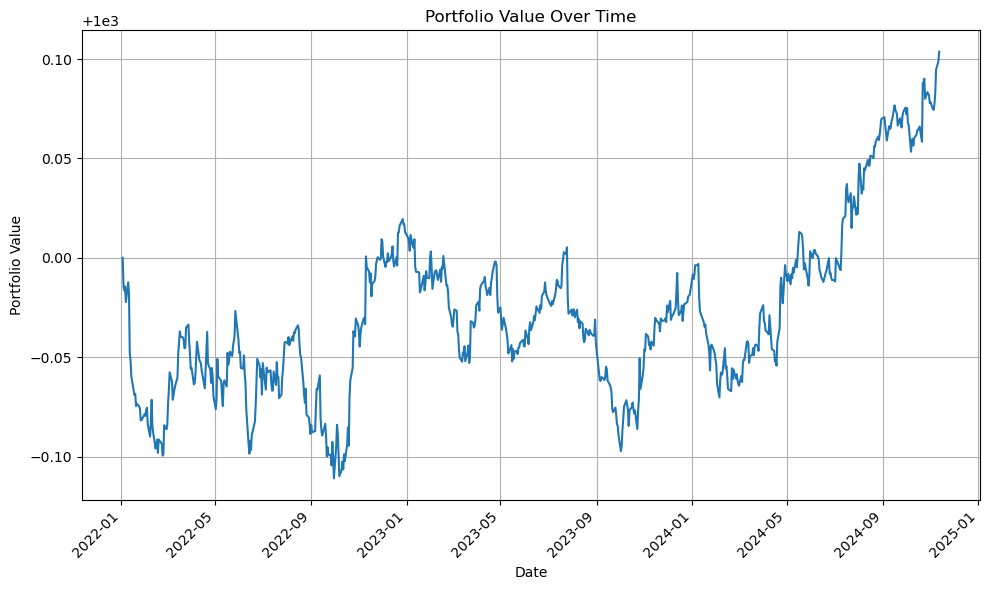

In [13]:
# Backtest function with Sharpe ratio calculation
def backtest(data, optimized_portfolio, long_short_tickers):
    # Calculate daily returns for each stock
    returns = data.pct_change().dropna()
    
    # Initialize portfolio value (starting with $1,000)
    initial_value = 1000
    portfolio_value = initial_value
    portfolio_history = [portfolio_value]
    
    # List to store portfolio daily returns
    portfolio_returns = []
    
    # Iterate through each day of returns
    for date in returns.index:
        # Calculate portfolio return for the day
        portfolio_return = sum(returns.loc[date, ticker] * optimized_portfolio[ticker] for ticker in long_short_tickers)
        
        # Update portfolio value based on the return
        portfolio_value *= (1 + portfolio_return)
        
        # Track portfolio value history
        portfolio_history.append(portfolio_value)
        
        # Store portfolio return for Sharpe ratio calculation
        portfolio_returns.append(portfolio_return)
    
    # Convert portfolio returns to a numpy array
    portfolio_returns = np.array(portfolio_returns)
    
    # Calculate Sharpe ratio (assuming risk-free rate = 0)
    mean_return = portfolio_returns.mean()
    std_deviation = portfolio_returns.std()
    sharpe_ratio = mean_return / std_deviation if std_deviation != 0 else 0  # Avoid division by zero
    
    return initial_value, portfolio_value, portfolio_history, sharpe_ratio

# Run the backtest
initial_value, final_value, portfolio_history, sharpe_ratio = backtest(data, optimized_portfolio, long_short_tickers)

# Print initial and final portfolio values and Sharpe ratio
print(f"Initial Portfolio Value: {initial_value}")
print(f"Final Portfolio Value: {final_value}")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Plot the portfolio value over time with improved x-axis readability
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(data.index, portfolio_history)

# Title and labels
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.show()


<H1> Reoptimization of Weights

Initial Portfolio Value: 1000
Final Portfolio Value: 1359.5452035148667
Sharpe Ratio: 0.054754145630153274


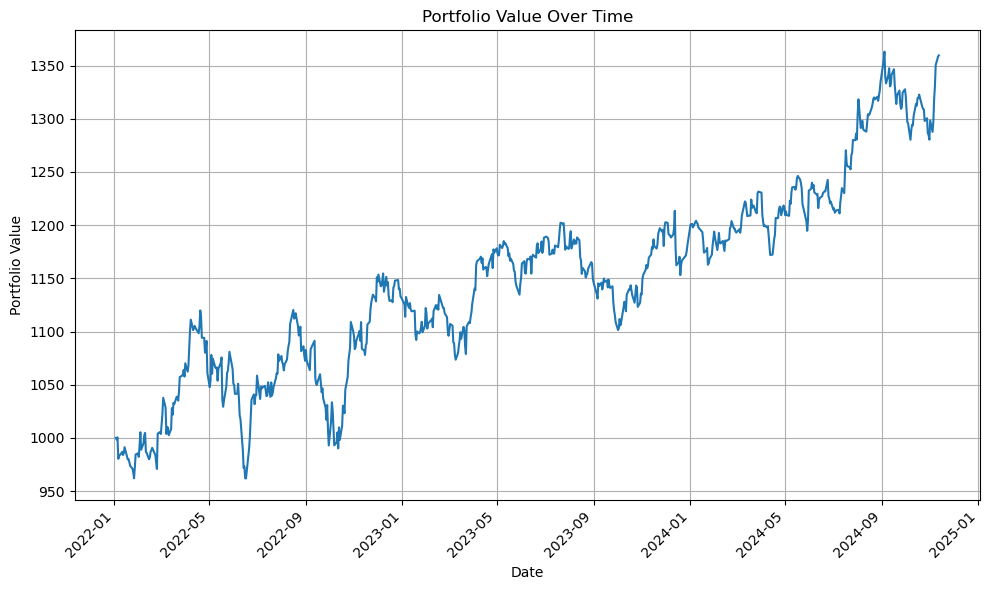

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def backtest(data, optimized_portfolio, long_short_tickers, betas, beta_threshold, reoptimize_function):
    # Calculate daily returns for each stock
    returns = data.pct_change().dropna()
    
    # Initialize portfolio value
    initial_value = 1000
    portfolio_value = initial_value
    portfolio_history = [portfolio_value]
    daily_returns = [] 
    
    # Iterate through each day of returns
    for date in returns.index:
        # Filter tickers based on beta at the current day
        filtered_betas = {ticker: beta for ticker, beta in betas.items() if beta < beta_threshold}
        
        # Update long_short_tickers to include only those with betas below the threshold
        filtered_tickers = [ticker for ticker in long_short_tickers if ticker in filtered_betas]
        
        # Reoptimize the portfolio weights based on filtered tickers
        new_optimized_portfolio = reoptimize_function(data[filtered_tickers])
        
        # Calculate portfolio return for the day using the new optimized weights
        portfolio_return = sum(returns.loc[date, ticker] * new_optimized_portfolio[ticker] for ticker in filtered_tickers)
        
        # Update portfolio value based on the return
        portfolio_value *= (1 + portfolio_return)
        
        # Track portfolio value and daily return history
        portfolio_history.append(portfolio_value)
        daily_returns.append(portfolio_return)
    
    # Calculate the average and standard deviation of daily returns
    avg_daily_return = np.mean(daily_returns)
    std_daily_return = np.std(daily_returns)
    
    # Calculate the Sharpe Ratio (assuming a risk-free rate of 0)
    sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else np.nan
    
    return initial_value, portfolio_value, portfolio_history, sharpe_ratio

# Define your reoptimization function (this is just an example and should be tailored to your specific method)
def reoptimize_function(filtered_data):
    # This function should return the optimized portfolio weights for the filtered tickers
    # For demonstration, assuming optimized weights are randomly generated for now
    optimized_weights = {ticker: 1 / len(filtered_data.columns) for ticker in filtered_data.columns}
    return optimized_weights

# Run the backtest
initial_value, final_value, portfolio_history, sharpe_ratio = backtest(data, optimized_portfolio, long_short_tickers, betas, beta_threshold, reoptimize_function)

# Print initial and final portfolio values and the Sharpe ratio
print(f"Initial Portfolio Value: {initial_value}")
print(f"Final Portfolio Value: {final_value}")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Plot the portfolio value over time
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(data.index, portfolio_history)

# Title and labels
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.show()
